<a href="https://colab.research.google.com/github/dr-irani/cs682-final-project/blob/master/notebooks/hate_speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  print("No GPU available")
  device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
import pandas as pd
import numpy as np
import os
import re
import string
import time
import datetime
import random

In [3]:
!pip install transformers
from transformers import BertTokenizer

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load and Preprocess Data

In [4]:
def deEmojify(inputString):
    """
    Found this on StackOverflow, have to confirm it's doing what I want
    """
    return inputString.encode('ascii', 'ignore').decode('ascii')

remove = string.punctuation
remove = remove.replace('<', '').replace('>', '') # remove token characters from punctuation list

df = pd.read_csv('/content/drive/My Drive/Final Projects/Deep Learning/hate_speech_labeled_data.csv').loc[:, ['tweet', 'class']].rename(columns={'class': 'label'})
df.tweet = df.apply(lambda x: re.sub(r'\B@\w+', '<user>', x.tweet), axis=1) # replace users with <user>
df.tweet = df.apply(lambda x: re.sub(r'(.)\1+', r'\1\1', x.tweet), axis=1) # remove character repetition from elongated words
df.tweet = df.apply(lambda x: re.sub(r'http\S+', '<url>', x.tweet), axis=1) # replace urls with <url>
df.tweet = df.apply(lambda x: re.sub(r'&#?\w+\d+', '', x.tweet), axis=1) # remove character reference codes
df.tweet = df.apply(lambda x: re.sub(r'#(\w+)', '<hashtag>', x.tweet), axis=1) # replace hashtags with <hashtag>
df.tweet = df.apply(lambda x: deEmojify(x.tweet), axis=1) # remove emoticons
df.tweet = df.apply(lambda x: re.sub(r'\d+', '<number>', x.tweet), axis=1) # replace numbers with <number>
df.tweet = df.apply(lambda x: x.tweet.translate({ord(c): None for c in remove}), axis=1) # remove punctuation
df.tweet = df.apply(lambda x: x.tweet.lower().strip(), axis=1) # lowercase and remove extra leading/trailing whitespace

print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 24,783



,tweet,label
16391,rt <user> still waiting for charlie baker to t...,2
978,mike calls me tbird <user>,2
22795,whipped <url>,2
18420,rt <user> sum hoes be smoking to look cute bit...,1
13360,niggas with bitch tendencies,1
8887,dumb ass hoe,1
4367,<user> <user> <user> \nchippah i hopes you ain...,1
13970,republicans take massachusetts governorship co...,2
21152,stern fixed the image of the league nba player...,1
14810,rt <user> when a bitch say i love you hit her ...,1


In [5]:
def compute_class_states(df):
    print('Hate: {}, Offensive: {}, Neither: {}, Total: {}'.format(len(df[df.label == 0]), len(df[df.label == 1]), len(df[df.label == 2]), len(df)))
compute_class_states(df)

Hate: 1430, Offensive: 19190, Neither: 4163, Total: 24783


Tokenize Data

In [6]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [7]:
tweets = df.tweet.values
labels = df.label.values

# Print the original sentence.
print('Original: ', tweets[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(tweets[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

Original:  rt <user> as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out
Tokenized:  ['rt', '<', 'user', '>', 'as', 'a', 'woman', 'you', 'shouldn', '##t', 'complain', 'about', 'cleaning', 'up', 'your', 'house', 'amp', 'as', 'a', 'man', 'you', 'should', 'always', 'take', 'the', 'trash', 'out']
Token IDs:  [19387, 1026, 5310, 1028, 2004, 1037, 2450, 2017, 5807, 2102, 17612, 2055, 9344, 2039, 2115, 2160, 23713, 2004, 1037, 2158, 2017, 2323, 2467, 2202, 1996, 11669, 2041]


In [8]:
max_len = 0

# For every sentence...
for tweet in tweets:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max tweet length: ', max_len)

Max tweet length:  62


In [9]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Original:  rt <user> as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out
Token IDs: tensor([  101, 19387,  1026,  5310,  1028,  2004,  1037,  2450,  2017,  5807,
         2102, 17612,  2055,  9344,  2039,  2115,  2160, 23713,  2004,  1037,
         2158,  2017,  2323,  2467,  2202,  1996, 11669,  2041,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


Train/Validation Split

In [10]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

19,826 training samples
2,478 validation samples
2,479 test samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset, # The test samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Load Model

In [12]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Optimizer and Learning Rate Scheduler

In [0]:
optimizer = AdamW(model.parameters(),
    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
)

In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Training Loop

In [0]:
def flat_accuracy(preds, labels):
    """
    Function to calculate the accuracy of our predictions vs labels
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    """
    Takes a time in seconds and returns a string hh:mm:ss
    """
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

prev_val_loss = float('inf')

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    # If validation loss is lower than previous, save the model.
    if avg_val_loss < prev_val_loss:
        output_dir = './model_save/'

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        best_model = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        best_model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)
    prev_val_loss = avg_val_loss

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    620.    Elapsed: 0:00:08.
  Batch    80  of    620.    Elapsed: 0:00:16.
  Batch   120  of    620.    Elapsed: 0:00:25.
  Batch   160  of    620.    Elapsed: 0:00:33.
  Batch   200  of    620.    Elapsed: 0:00:41.
  Batch   240  of    620.    Elapsed: 0:00:49.
  Batch   280  of    620.    Elapsed: 0:00:57.
  Batch   320  of    620.    Elapsed: 0:01:06.
  Batch   360  of    620.    Elapsed: 0:01:14.
  Batch   400  of    620.    Elapsed: 0:01:22.
  Batch   440  of    620.    Elapsed: 0:01:30.
  Batch   480  of    620.    Elapsed: 0:01:38.
  Batch   520  of    620.    Elapsed: 0:01:47.
  Batch   560  of    620.    Elapsed: 0:01:55.
  Batch   600  of    620.    Elapsed: 0:02:03.

  Average training loss: 0.13
  Training epcoh took: 0:02:07

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.27
  Validation took: 0:00:05

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    620.    Elapsed: 0:00:08.
  Batch  

In [23]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.13,0.27,0.91,0:02:07,0:00:05
2,0.12,0.27,0.91,0:02:07,0:00:05
3,0.13,0.27,0.91,0:02:07,0:00:05


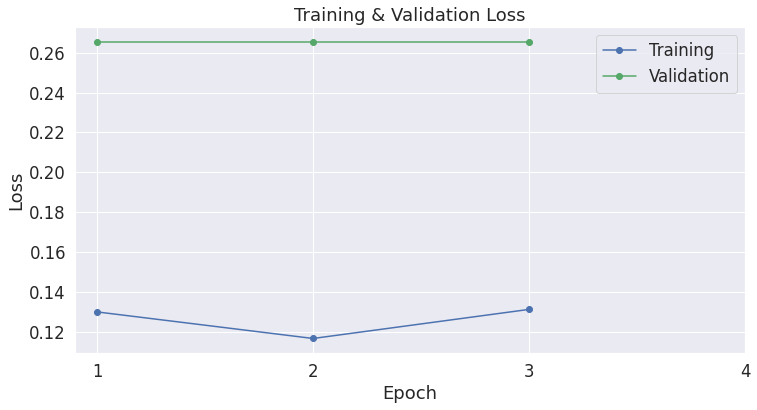

In [24]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

Evaluation on Test Set

In [25]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [27]:
from sklearn.metrics import classification_report

# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate precision/recall/f1
scores = classification_report(flat_true_labels, flat_predictions)

print(scores)

              precision    recall  f1-score   support

           0       0.55      0.42      0.48       151
           1       0.94      0.96      0.95      1930
           2       0.89      0.87      0.88       398

    accuracy                           0.91      2479
   macro avg       0.79      0.75      0.77      2479
weighted avg       0.91      0.91      0.91      2479



Move model files to Drive

In [0]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/My Drive/Final Projects/Deep Learning/BERT Fine-Tuning/HateSpeechDetection"

SEAT

In [0]:
from compute_seat import SEAT, create_target_attribute_lists, A_words, B_words

with open('/content/drive/My Drive/Final Projects/Deep Learning/Names/40_white_names.txt', 'r') as f:
    X_words = f.read().splitlines()
with open('/content/drive/My Drive/Final Projects/Deep Learning/Names/40_black_names.txt', 'r') as f:
    Y_words = f.read().splitlines()

A, B, X, Y = create_target_attribute_lists(X_words, Y_words, A_words, B_words)
seat = SEAT('./drive/My Drive/Final Projects/Deep Learning/BERT Fine-Tuning/HateSpeechDetection/model_save/')
m, seat_score, effect_size = seat.run_seat(A, B, X, Y)

In [5]:
print("seat score: %f" % seat_score)
print("effect size: %f" % effect_size)

seat score: 0.003099
effect size: 0.930363


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


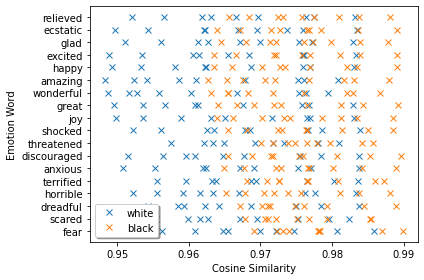

In [3]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# attributes: A - fear, B - joy
# target: X - white names, Y - black names
targ_size = len(X)
attr_size = len(A)

fig = plt.figure()
ax = plt.subplot(111)
emotions = A_words + B_words

for i in range(m.shape[0]):
  if i < targ_size:
    race = "white"
    c = 'C0'
  else:
    race = "black"
    c = 'C1'    
  for j in range(m.shape[1]):
    ax.plot(m[i, j], emotions[j//3], 'x', color=c, label=race if (i==0 or i==targ_size) and j==0 else "")

# for i in range(targ_size, m.shape[0]):
#   for j in range(m.shape[1]):
#     ax.plot(m[i, j], emotions[j//3], 'x', c = 'orange', label='black')

ax.legend(loc='best', ncol=1, fancybox=True, shadow=True)
plt.xlabel('Cosine Similarity')
plt.ylabel('Emotion Word')
plt.tight_layout()
plt.savefig('/content/names_seat.png')